In [15]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [16]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [17]:
import sys
import os
import logging

# Add src to path so we can import modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Configure logging to see what's happening under the hood
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from invention_assistant_graph import run_all_analysts_parallel, generate_markdown_report

2025-12-02 02:03:08,376 - INFO - Initializing RAG system for graph...


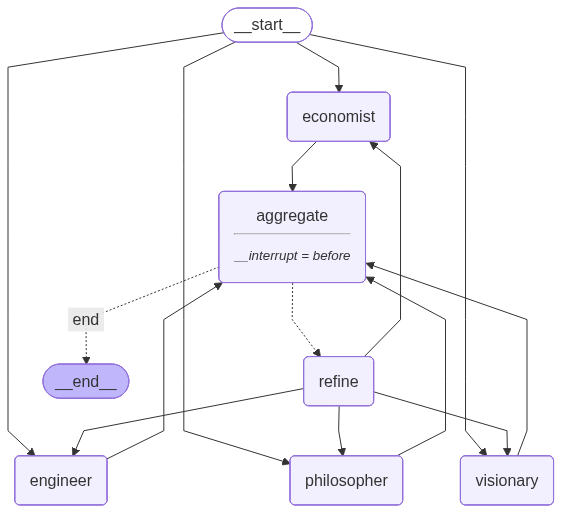

In [18]:
from invention_assistant_graph import create_invention_graph
from IPython.display import Image, display

# Create the graph
graph = create_invention_graph()

# Generate and display the graph visualization
try:
    # LangGraph can generate a Mermaid diagram or PNG
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Graph visualization requires graphviz. Error: {e}")

## tell us about your invention


In [19]:
invention = {
   "title": "study manager",
    "description": "An LLM that organizes notes for you, builds up quiz questions and answers, and helps you prepare for exams."

}

print(f"Analyzing Invention: {invention['title']}")

Analyzing Invention: study manager


## Run the LangGraph Analysis

This step invokes the `StateGraph` which:
- Starts 4 analyst nodes in parallel.
- Each node retrieves RAG context.
- Each node calls the LLM with the enriched prompt.
- The `aggregate` node combines the results.

In [20]:
result = run_all_analysts_parallel(invention)

2025-12-02 02:03:14,493 - INFO - Initializing RAG system for graph...
2025-12-02 02:03:14,501 - INFO - Starting graph execution with thread_id: c90b7252-e528-4500-b802-d06a696d9403
2025-12-02 02:03:14,501 - INFO - Running analysts (Engineer, Philosopher, Economist, Visionary)...
2025-12-02 02:03:14,507 - INFO - Economist node: Analyzing invention
2025-12-02 02:03:14,515 - INFO - Engineer node: Analyzing invention
2025-12-02 02:03:14,515 - INFO - Philosopher node: Analyzing invention
2025-12-02 02:03:14,520 - INFO - Visionary node: Analyzing invention
2025-12-02 02:03:14,990 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-02 02:03:14,992 - INFO - Retrieved 3 chunks for query: An LLM that organizes notes for you, builds up qui...
2025-12-02 02:03:14,992 - INFO - Retrieved 3 context chunks for visionary
2025-12-02 02:03:15,068 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-02 02:03:15,070 - INFO - Retri

In [21]:
import uuid
from invention_assistant_graph import create_invention_graph, InventionState

# 1. Setup Graph and Config
graph = create_invention_graph()
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print(f"Created session with thread_id: {thread_id}")

# 2. Define Input
initial_state = {
    "invention": invention,
    "engineer_analysis": {},
    "philosopher_analysis": {},
    "economist_analysis": {},
    "visionary_analysis": {},
    "transcript": [],
    "aggregated_scorecard": {},
    "errors": []
}

# 3. Run until interruption
print("Running analysts... (Graph will pause before aggregation)")
for event in graph.stream(initial_state, config=config, stream_mode="values"):
    # Just print the keys to show progress
    pass

print("\n Graph PAUSED! Waiting for human review.")

2025-12-02 02:03:21,196 - INFO - Initializing RAG system for graph...
2025-12-02 02:03:21,207 - INFO - Economist node: Analyzing invention
2025-12-02 02:03:21,211 - INFO - Engineer node: Analyzing invention
2025-12-02 02:03:21,214 - INFO - Philosopher node: Analyzing invention
2025-12-02 02:03:21,218 - INFO - Visionary node: Analyzing invention


Created session with thread_id: d1ae38fd-a575-494f-8e49-73228521f511
Running analysts... (Graph will pause before aggregation)


2025-12-02 02:03:21,679 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-02 02:03:21,682 - INFO - Retrieved 3 chunks for query: An LLM that organizes notes for you, builds up qui...
2025-12-02 02:03:21,683 - INFO - Retrieved 3 context chunks for engineer
2025-12-02 02:03:21,816 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-02 02:03:21,818 - INFO - Retrieved 3 chunks for query: An LLM that organizes notes for you, builds up qui...
2025-12-02 02:03:21,818 - INFO - Retrieved 3 context chunks for philosopher
2025-12-02 02:03:21,899 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-02 02:03:21,902 - INFO - Retrieved 3 chunks for query: An LLM that organizes notes for you, builds up qui...
2025-12-02 02:03:21,902 - INFO - Retrieved 3 context chunks for visionary
2025-12-02 02:03:21,902 - INFO - Using OpenAI API for LLM call (this may incur cost)
2025-12-02 02:03:22,


 Graph PAUSED! Waiting for human review.


In [22]:
# Fetch current state
current_values = graph.get_state(config).values
engineer_analysis = current_values["engineer_analysis"]

print("Available keys:", engineer_analysis.keys())

# Let's try to update 'analysis' or 'recommendation' or whatever key exists
target_key = "analysis" if "analysis" in engineer_analysis else list(engineer_analysis.keys())[0]

# Modify the analysis
original_text = engineer_analysis.get(target_key, "")
engineer_analysis[target_key] = str(original_text) + " [HUMAN NOTE: Verify the invention is safe!]"

# Update the graph state with the change
# We MUST specify as_node="engineer" because multiple nodes ran in parallel
graph.update_state(config, {"engineer_analysis": engineer_analysis}, as_node="engineer")

print(f" Updated Engineer's '{target_key}' with human feedback.")

Available keys: dict_keys(['transcript', 'scorecard'])
 Updated Engineer's 'transcript' with human feedback.


In [23]:
# Fetch the current state of the graph
current_state = graph.get_state(config)
state_values = current_state.values

print("--- Analyst Insights ---\n")
for role in ["engineer", "philosopher", "economist", "visionary"]:
    analysis = state_values.get(f"{role}_analysis", {})
    print(f"👤 {role.upper()} Keys: {list(analysis.keys())}")
    
    # Try to find some content to print
    if "transcript" in analysis and analysis["transcript"]:
        # Print the first message content
        print(f"   Message: {analysis['transcript'][0].get('message', '')[:100]}...")
    elif "raw" in analysis:
        print(f"   Raw: {str(analysis['raw'])[:100]}...")
    else:
        print(f"   Content: {str(analysis)[:100]}...")
    print()

print("\nNext node to run:", current_state.next)

--- Analyst Insights ---

👤 ENGINEER Keys: ['transcript', 'scorecard']


AttributeError: 'str' object has no attribute 'get'

In [41]:
print("Resuming graph to calculate final score...")

# Pass None to resume from where we left off
final_event = None
for event in graph.stream(None, config=config, stream_mode="values"):
    final_event = event

result = {
    "transcript": final_event.get("transcript", []),
    "scorecard": final_event.get("aggregated_scorecard", {}),
    "analyses": {
        "engineer": final_event.get("engineer_analysis", {}),
        "philosopher": final_event.get("philosopher_analysis", {}),
        "economist": final_event.get("economist_analysis", {}),
        "visionary": final_event.get("visionary_analysis", {})
    }
}

print("🏁 Analysis Complete!")

Resuming graph to calculate final score...
🏁 Analysis Complete!


## Generate and Display Report

We use the `report_generator` to create a professional Markdown report from the graph state.

In [42]:
from IPython.display import Markdown, display

report = generate_markdown_report(result)
display(Markdown(report))

# Invention Analysis Report

## Executive Summary

**Final Decision:** ✅ APPROVE

**Rationale:** Overall strong evaluation across analysts. Proceed with development.

## Scorecard Summary

| Dimension | Score (1-5) | Assessment |
|---|---|---|
| **Technical Rigor** | 3.8/5 ▓▓▓░░ | See details below |
| **Originality** | 3.2/5 ▓▓▓░░ | See details below |
| **Feasibility** | 3.5/5 ▓▓▓░░ | See details below |
| **Impact** | 3.8/5 ▓▓▓░░ | See details below |

## Analyst Perspectives

### 👤 Economist

The invention of an LLM that organizes notes, builds quiz questions, and aids exam preparation has significant market viability and economic impact potential. The market sizing can be substantial given the demand for educational tools and services. The revenue potential lies in subscription models or one-time purchases. The cost structure analysis should consider COGS, operating costs, and customer acquisition costs. The competitive landscape may include existing educational platforms and tools, but differentiation through quiz question generation can be a unique selling point. Adoption barriers may include regulatory compliance for educational content and cultural preferences for traditional study methods.

### 👤 Engineer

The invention of an LLM that organizes notes, builds quiz questions, and helps prepare for exams presents an interesting application of technology in education. However, there are several technical aspects that need to be considered for its successful implementation.

### 👤 Philosopher

The invention of an LLM that organizes notes, builds quiz questions, and helps prepare for exams raises important ethical considerations.

### 👤 Visionary

The invention of an LLM that organizes notes, builds quiz questions, and aids exam preparation has significant transformative potential in the field of education. In the 5-year impact, it could streamline study processes and enhance learning outcomes for students. Looking ahead to the 10-20 year vision, this technology could reshape the education industry by personalizing learning experiences and revolutionizing assessment methods. The systemic implications include improved educational access and equity, as well as potential shifts in traditional teaching paradigms. Risk and opportunity pairs involve the upside of enhanced student engagement and knowledge retention, alongside the downside of overreliance on automated learning processes.

## Detailed Evidence & Risks

### Technical Rigor
- The LLM must be able to efficiently organize and retrieve notes to provide accurate quiz questions and answers.
- The system should have robust data processing capabilities to handle large volumes of information.
- The technical aspects of the LLM system seem well-developed and functional.

### Originality
- The concept of automatically generating quiz questions from notes is innovative and can enhance learning efficiency.
- The integration of exam preparation features sets this invention apart from traditional note-taking tools.
- While similar tools exist, the integration of note organization, quiz generation, and exam preparation is a novel approach.

### Feasibility
- The feasibility of the LLM depends on the accuracy of quiz question generation and the effectiveness of exam preparation assistance.
- Integration with existing educational platforms and tools may pose technical challenges.
- The feasibility of implementing such a system depends on the availability of resources and user adoption.

### Impact
- If successful, the LLM could streamline study processes for students and improve learning outcomes.
- The impact would be significant in educational settings where effective note-taking and exam preparation are crucial.
- The impact of this invention could be significant in aiding learning and study efficiency.



## Inspect the Raw Graph State (Optional)

You can also look at the raw output dictionary to see the individual analyses and scorecard data.

In [39]:
import json
print(json.dumps(result['scorecard'], indent=2))

{
  "technical_rigor": {
    "score": 3.8,
    "evidence": [
      "The LLM must be able to efficiently organize and retrieve notes to provide accurate quiz questions and answers.",
      "The system should have robust data processing capabilities to handle large volumes of information.",
      "The technical aspects of the LLM system seem well-developed and functional."
    ]
  },
  "originality": {
    "score": 3.2,
    "evidence": [
      "The concept of automatically generating quiz questions from notes is innovative and can enhance learning efficiency.",
      "The integration of exam preparation features sets this invention apart from traditional note-taking tools.",
      "While similar tools exist, the integration of note organization, quiz generation, and exam preparation is a novel approach."
    ]
  },
  "feasibility": {
    "score": 3.5,
    "evidence": [
      "The feasibility of the LLM depends on the accuracy of quiz question generation and the effectiveness of exam prep